In [ ]:
!pip install matplotlib
!pip install web3
!pip install sqlite3

In [1]:
import datetime
import json
from tqdm import tqdm
from web3 import Web3
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Connect to the Ethereum network
# Load secrets from the JSON file

with open('secrets.json') as f:
    print('started')
    secrets = json.load(f)
print(secrets)

# Extract the contract address
infura_url = secrets['infura_url']

web3 = Web3(Web3.HTTPProvider(infura_url))
assert web3.is_connected(), "Connection to Infura failed"

started
{'infura_url': 'https://mainnet.infura.io/v3/14f2ba82453045b69d13fa1685498ba6'}


In [9]:
# USDC Contract details
contract_address = Web3.to_checksum_address('0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48')
with open('abi.json') as f:
    abi = json.load(f)

contract_abi = abi["contract_abi"]

contract = web3.eth.contract(address=contract_address, abi=contract_abi)
from_block = 19823284  # Example start block, adjust based on your needs
to_block = web3.eth.block_number  # Fetch up to the most recent block
print('fromblock',from_block)
print('toblock',to_block)

fromblock 19823284
toblock 19873479


In [10]:
def fetch_logs(from_block, to_block):
    try:
        filter_params = {
            'fromBlock': from_block,
            'toBlock': to_block,
            'address': contract_address,
            'topics': [web3.keccak(text='Transfer(address,address,uint256)').hex()]
        }

        return web3.eth.get_logs(filter_params)

    except ValueError as e:
        if 'query returned more than 10000 results' in str(e):
            # Find midpoint of the block range
            mid_block = (from_block + to_block) // 2
            # Recursively fetch logs in smaller ranges
            return fetch_logs(from_block, mid_block) + \
                    fetch_logs(mid_block + 1, to_block)
        else:
            raise

In [11]:
logs = fetch_logs(from_block, to_block)
print(f"Number of logs fetched: {len(logs)}")

Number of logs fetched: 556249


In [12]:
transfers = []
# The transaction history should save:
# block number,
# transaction hash,
# tx index,
# event index,
# from address,
# to address,
# amount,
# time of event/tx
block_timestamp_map = {}
unique_map = {}

for log in tqdm(logs):
    try:
        event_data = contract.events.Transfer().process_log(log)
        blockNumber = log['blockNumber']
        if blockNumber not in block_timestamp_map:
            block = web3.eth.get_block(blockNumber)
            timestamp = datetime.datetime.utcfromtimestamp(block['timestamp']).strftime('%Y-%m-%d %H:%M:%S')
            block_timestamp_map[blockNumber] = timestamp
        else:
            timestamp = block_timestamp_map[blockNumber]
        key = str(log['blockNumber']) + '_' + str(log['logIndex'])
        if key not in unique_map:
            transfers.append((
                log['blockNumber'],
                log['transactionHash'].hex(),
                log['transactionIndex'],
                log['logIndex'],
                event_data.args['from'],
                event_data.args['to'],
                event_data.args['value'],
                log['blockHash'].hex(),
                timestamp))
            unique_map[key] = True

        # print(transfers)

    except Exception as e:
        print(f"Failed to decode log: {log} with error: {e}")

 11%|███████▉                                                                | 61233/556249 [43:25<22:24:57,  6.13it/s]

Failed to decode log: AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blockHash': HexBytes('0x66b998a1cf16cbb88d61801bc5a24959a498f298cae5893f88e0fe64e1c91fa6'), 'blockNumber': 19828208, 'data': HexBytes('0x000000000000000000000000000000000000000000000000000000006f890164'), 'logIndex': 32, 'removed': False, 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x00000000000000000000000088e6a0c2ddd26feeb64f039a2c41296fcb3f5640'), HexBytes('0x0000000000000000000000003fc91a3afd70395cd496c647d5a6cc9d4b2b7fad')], 'transactionHash': HexBytes('0xadc25bdd89b4a9ea2df8274760853300dd2b81fc938546978238aac0b90f5b8f'), 'transactionIndex': 20}) with error: {'code': -32603, 'message': 'service temporarily unavailable'}


 46%|███████████████████████████████▉                                     | 257469/556249 [2:44:28<31:13:56,  2.66it/s]

Failed to decode log: AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blockHash': HexBytes('0x45c4dddbcb44fc7499c0cb36e1f8a1d28f185ace1a4b598064ba1066f3a0cf16'), 'blockNumber': 19845230, 'data': HexBytes('0x000000000000000000000000000000000000000000000000000000000533debc'), 'logIndex': 43, 'removed': False, 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x0000000000000000000000009c1f56449f3658a69914b2cd4825eeef3408b6c2'), HexBytes('0x000000000000000000000000919f9173e2dc833ec708812b4f1cb11b1a17efde')], 'transactionHash': HexBytes('0x9f88e2b568f844eaaa1e2728ab7586667f1e70c53eff13157a8a56ce047f6c6f'), 'transactionIndex': 10}) with error: {'code': -32603, 'message': 'service temporarily unavailable'}


 56%|██████████████████████████████████████▎                              | 309209/556249 [3:22:37<19:03:47,  3.60it/s]

Failed to decode log: AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blockHash': HexBytes('0xa5dff0452aeeeda99f4df82c6024d6c0fc96e900312643f1391568aa6f97ca5d'), 'blockNumber': 19851417, 'data': HexBytes('0x00000000000000000000000000000000000000000000000000000003922afdea'), 'logIndex': 224, 'removed': False, 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x000000000000000000000000a1a51cb9c30d8ac6ebc795127328d977cb39f748'), HexBytes('0x0000000000000000000000008ad599c3a0ff1de082011efddc58f1908eb6e6d8')], 'transactionHash': HexBytes('0x274812e366ea6e68f1b69f0941a30134e83bdf778aa0d9b39dec097534cebabd'), 'transactionIndex': 45}) with error: {'code': -32603, 'message': 'service temporarily unavailable'}


 67%|█████████████████████████████████████████████▉                       | 370301/556249 [4:06:36<82:48:16,  1.60s/it]

Failed to decode log: AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blockHash': HexBytes('0x014e3f6ffd99f134f859f7a968297bd710d5df596f0cbe9cf551c311fd9f20e6'), 'blockNumber': 19857966, 'data': HexBytes('0x000000000000000000000000000000000000000000000000000000003b9aca00'), 'logIndex': 9, 'removed': False, 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x00000000000000000000000015f26ad90ab76d455202e939e795eb3b56d90483'), HexBytes('0x000000000000000000000000f7b8720cb087f69dd56507ea1e4065adf6edaeb3')], 'transactionHash': HexBytes('0x39395219108467c8c4b33d17e3cd6a59617b52241d63f10bda77f32adf36552e'), 'transactionIndex': 18}) with error: HTTPSConnectionPool(host='mainnet.infura.io', port=443): Max retries exceeded with url: /v3/14f2ba82453045b69d13fa1685498ba6 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000017E653B9F50>: Failed to resolve 'mainnet.infura.io' ([Errno 11001] ge

 67%|█████████████████████████████████████████████▉                       | 370302/556249 [4:06:37<82:14:31,  1.59s/it]

Failed to decode log: AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blockHash': HexBytes('0x014e3f6ffd99f134f859f7a968297bd710d5df596f0cbe9cf551c311fd9f20e6'), 'blockNumber': 19857966, 'data': HexBytes('0x000000000000000000000000000000000000000000000000000000001492b940'), 'logIndex': 38, 'removed': False, 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x000000000000000000000000d64e405fba9f1f356f2fe6edba13e1103ce952e1'), HexBytes('0x0000000000000000000000009a0b7083c4b4a75c46532df1ea6b2a5957f0c36f')], 'transactionHash': HexBytes('0xfcf5c3f222f29873191f897d2b9a22353e6ec7cf10f49e981b6976c9d57e83c4'), 'transactionIndex': 44}) with error: HTTPSConnectionPool(host='mainnet.infura.io', port=443): Max retries exceeded with url: /v3/14f2ba82453045b69d13fa1685498ba6 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000017E65393490>: Failed to resolve 'mainnet.infura.io' ([Errno 11001] g

 67%|█████████████████████████████████████████████▉                       | 370303/556249 [4:06:38<81:22:43,  1.58s/it]

Failed to decode log: AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blockHash': HexBytes('0x014e3f6ffd99f134f859f7a968297bd710d5df596f0cbe9cf551c311fd9f20e6'), 'blockNumber': 19857966, 'data': HexBytes('0x0000000000000000000000000000000000000000000000000000000003b45570'), 'logIndex': 39, 'removed': False, 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x000000000000000000000000198b1b80afab1df283f10d7d3b07e6cb3ec62660'), HexBytes('0x00000000000000000000000058dcf9b06bb77a95d15757da1414da6472c54bec')], 'transactionHash': HexBytes('0x119d3e3ee1607b4ea44ff36d427aa93ef2541cef977829151889e2cc2fc0e1d6'), 'transactionIndex': 45}) with error: HTTPSConnectionPool(host='mainnet.infura.io', port=443): Max retries exceeded with url: /v3/14f2ba82453045b69d13fa1685498ba6 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000017E653B8A50>: Failed to resolve 'mainnet.infura.io' ([Errno 11001] g

 67%|█████████████████████████████████████████████▉                       | 370304/556249 [4:06:39<80:15:46,  1.55s/it]

Failed to decode log: AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blockHash': HexBytes('0x014e3f6ffd99f134f859f7a968297bd710d5df596f0cbe9cf551c311fd9f20e6'), 'blockNumber': 19857966, 'data': HexBytes('0x0000000000000000000000000000000000000000000000000000000001c9c380'), 'logIndex': 47, 'removed': False, 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x000000000000000000000000974caa59e49682cda0ad2bbe82983419a2ecc400'), HexBytes('0x0000000000000000000000008dd89b7ea5ab678c17fd0b33baa9642227710b51')], 'transactionHash': HexBytes('0x8530f085986cfdbcb35ada184e30daf54cfd39100d3702dfe6cb9df5cea548d5'), 'transactionIndex': 54}) with error: HTTPSConnectionPool(host='mainnet.infura.io', port=443): Max retries exceeded with url: /v3/14f2ba82453045b69d13fa1685498ba6 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000017E62E04E50>: Failed to resolve 'mainnet.infura.io' ([Errno 11001] g

 67%|█████████████████████████████████████████████▉                       | 370305/556249 [4:06:41<78:49:09,  1.53s/it]

Failed to decode log: AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blockHash': HexBytes('0x014e3f6ffd99f134f859f7a968297bd710d5df596f0cbe9cf551c311fd9f20e6'), 'blockNumber': 19857966, 'data': HexBytes('0x000000000000000000000000000000000000000000000000000000009e1038be'), 'logIndex': 68, 'removed': False, 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x00000000000000000000000077493e16423499eece608e146fe0826685f2e23d'), HexBytes('0x0000000000000000000000008865f00dafc023036434616b736be315b8360d58')], 'transactionHash': HexBytes('0x41a6c7de946db47b3ba6931da482ffe24148045b37ddd34106fbb03285ad1599'), 'transactionIndex': 64}) with error: HTTPSConnectionPool(host='mainnet.infura.io', port=443): Max retries exceeded with url: /v3/14f2ba82453045b69d13fa1685498ba6 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000017E653B8890>: Failed to resolve 'mainnet.infura.io' ([Errno 11001] g

 67%|█████████████████████████████████████████████▉                       | 370306/556249 [4:06:42<77:11:27,  1.49s/it]

Failed to decode log: AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blockHash': HexBytes('0x014e3f6ffd99f134f859f7a968297bd710d5df596f0cbe9cf551c311fd9f20e6'), 'blockNumber': 19857966, 'data': HexBytes('0x000000000000000000000000000000000000000000000000000000012a05f200'), 'logIndex': 91, 'removed': False, 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x00000000000000000000000079b918243c88509e220a6705adf642034b087d58'), HexBytes('0x000000000000000000000000f8cead8a60f29d44c6d837c38b564b5916ba6a3f')], 'transactionHash': HexBytes('0xa490ee9b393f401437ab9a26eea1726df76a3af43ee8b0e75c2e15caa5e087a2'), 'transactionIndex': 80}) with error: HTTPSConnectionPool(host='mainnet.infura.io', port=443): Max retries exceeded with url: /v3/14f2ba82453045b69d13fa1685498ba6 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000017E65392050>: Failed to resolve 'mainnet.infura.io' ([Errno 11001] g

 67%|█████████████████████████████████████████████▉                       | 370307/556249 [4:06:43<75:28:23,  1.46s/it]

Failed to decode log: AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blockHash': HexBytes('0x014e3f6ffd99f134f859f7a968297bd710d5df596f0cbe9cf551c311fd9f20e6'), 'blockNumber': 19857966, 'data': HexBytes('0x0000000000000000000000000000000000000000000000000000000007270e00'), 'logIndex': 116, 'removed': False, 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x0000000000000000000000006e3286fca50a006697d32eeb17ba4279e310f47f'), HexBytes('0x00000000000000000000000055fe002aeff02f77364de339a1292923a15844b8')], 'transactionHash': HexBytes('0xb647aeaa2a6504ebc77ea3cb593f06010bc76361b934d3a8efabb5a243680cf8'), 'transactionIndex': 84}) with error: HTTPSConnectionPool(host='mainnet.infura.io', port=443): Max retries exceeded with url: /v3/14f2ba82453045b69d13fa1685498ba6 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000017E653B9150>: Failed to resolve 'mainnet.infura.io' ([Errno 11001] 

 71%|██████████████████████████████████████████████████▊                     | 392619/556249 [4:17:34<39:10, 69.61it/s]

Failed to decode log: AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blockHash': HexBytes('0x395c25089ee22790f20ea86e65829a07e542a33666735af3c0656441fbe1e395'), 'blockNumber': 19859729, 'data': HexBytes('0x0000000000000000000000000000000000000000000000000000003ae34c5a20'), 'logIndex': 1, 'removed': False, 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x000000000000000000000000a69babef1ca67a37ffaf7a485dfff3382056e78c'), HexBytes('0x00000000000000000000000099ac8ca7087fa4a2a1fb6357269965a2014abc35')], 'transactionHash': HexBytes('0x257b22e9201e37122b8f89a17edc08f158d4ffa2054f2b268480797dbb5dc5a7'), 'transactionIndex': 0}) with error: {'code': -32603, 'message': 'service temporarily unavailable, retry in 10s'}


100%|████████████████████████████████████████████████████████████████████████| 556249/556249 [6:05:45<00:00, 25.35it/s]


In [13]:
def transaction_exists(cursor, transaction_hash, event_index):
    cursor.execute('''
        SELECT EXISTS(
            SELECT 1 FROM transactions WHERE transaction_hash=? AND event_index=?
        )
    ''', (transaction_hash, event_index))
    return cursor.fetchone()[0]

In [14]:
# Connect to SQLite database
conn = sqlite3.connect('usdc_transactions.db')
c = conn.cursor()
# Create table if doesnt exist
c.execute('''
CREATE TABLE IF NOT EXISTS transactions (
    block_number INTEGER,
    transaction_hash TEXT,
    transaction_index INTEGER,
    event_index INTEGER,
    from_address TEXT,
    to_address TEXT,
    value REAL,
    block_hash TEXT,
    timestamp DATETIME,
    UNIQUE(block_number, event_index) ON CONFLICT REPLACE
);
''')
print("created table")

created table


In [15]:
# Use a transaction to bulk insert data
c.execute('BEGIN TRANSACTION')

try:
    c.executemany('''INSERT INTO transactions (block_number, transaction_index, event_index, transaction_hash, 
    from_address, to_address, value, block_hash, timestamp) 
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?) 
    ''', transfers)
    conn.commit()
except Exception as e:
    print("An error occurred during SQL insert:", e)
    conn.rollback()

conn.close()

In [16]:
# Connect to the database
conn = sqlite3.connect('usdc_transactions.db')

# Query to fetch all transactions
query = """
SELECT block_number, transaction_hash, from_address, to_address, value, timestamp
FROM transactions
"""

In [17]:
# Load data into a DataFrame
df = pd.read_sql_query(query, conn)

# Ensure 'timestamp' is a datetime type for further analysis
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [18]:
# Derive the total number of hours and days from the data
total_hours = int((df['timestamp'].max() - df['timestamp'].min()) / pd.Timedelta(hours=1)) + 1
total_days = int((df['timestamp'].max() - df['timestamp'].min()) / pd.Timedelta(days=1)) + 1

# Calculate the total number of transactions
total_transactions = df.shape[0]

# Calculate the average number of transfers per hour and per day
transfers_per_hour = total_transactions / total_hours
transfers_per_day = total_transactions / total_days

print(f"Average No of Transfers per Hour: {transfers_per_hour}")
print(f"Average No of Transfers per Day: {transfers_per_day}")

# Calculate the total transfer amount
total_transfer_amount = df['value'].sum()

# Calculate the average transfer amount per hour and per day
average_transfer_amount_per_hour = total_transfer_amount / total_hours
average_transfer_amount_per_day = total_transfer_amount / total_days

print(f"Average Transfer Amount per Hour: {average_transfer_amount_per_hour / 10**6} million")
print(f"Average Transfer Amount per Day: {average_transfer_amount_per_day / 10**6} million")

Average No of Transfers per Hour: 2170.579881656805
Average No of Transfers per Day: 45853.5
Average Transfer Amount per Hour: 216012741.46957767 million
Average Transfer Amount per Day: 4563269163.544828 million


In [19]:
# Extract hour and date from timestamp
df['hour'] = df['timestamp'].dt.hour
df['date'] = df['timestamp'].dt.date

# Calculate distributions
transfer_hourly_distribution = df.groupby('hour')['value'].sum() / 10**6
transfer_hourly_distribution_freq = df.groupby('hour').size()
transfer_daily_distribution = df.groupby('date')['value'].sum() / 10**6
transfer_daily_distribution_freq = df.groupby('date').size()

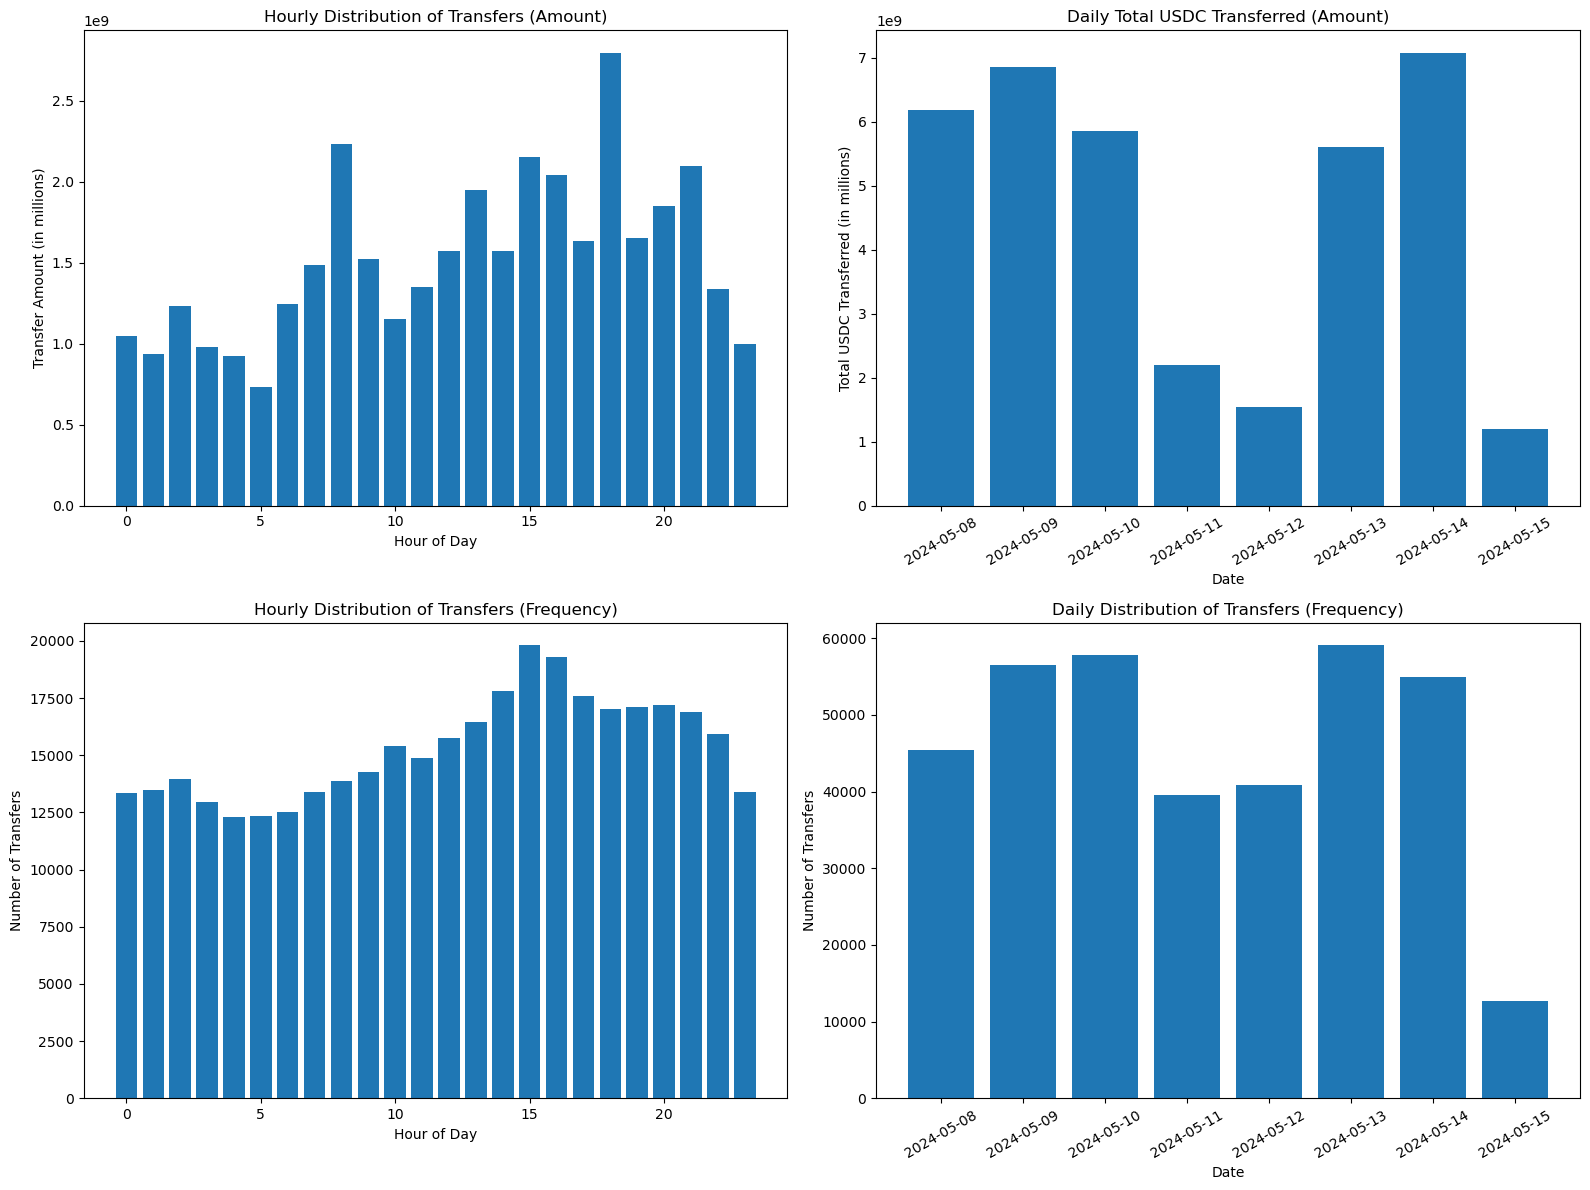

In [20]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot the hourly distribution of transfer amounts
axs[0, 0].bar(transfer_hourly_distribution.index, transfer_hourly_distribution.values)
axs[0, 0].set_title('Hourly Distribution of Transfers (Amount)')
axs[0, 0].set_xlabel('Hour of Day')
axs[0, 0].set_ylabel('Transfer Amount (in millions)')

# Plot the daily distribution of transfer amounts
axs[0, 1].bar(transfer_daily_distribution.index, transfer_daily_distribution.values)
axs[0, 1].set_title('Daily Total USDC Transferred (Amount)')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Total USDC Transferred (in millions)')
axs[0, 1].tick_params(axis='x', rotation=30)

# Plot the hourly distribution of transfer frequencies
axs[1, 0].bar(transfer_hourly_distribution_freq.index, transfer_hourly_distribution_freq.values)
axs[1, 0].set_title('Hourly Distribution of Transfers (Frequency)')
axs[1, 0].set_xlabel('Hour of Day')
axs[1, 0].set_ylabel('Number of Transfers')

# Plot the daily distribution of transfer frequencies
axs[1, 1].bar(transfer_daily_distribution_freq.index, transfer_daily_distribution_freq.values)
axs[1, 1].set_title('Daily Distribution of Transfers (Frequency)')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Number of Transfers')
axs[1, 1].tick_params(axis='x', rotation=30)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()